# Using Embeddings for News Classification (week 8)

## Imports

In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [2]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        # title_vocab._token_to_idx: {'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'jobs': 4, 'tax': 5, 'cuts': 6,  
        #                             ......, 'shiite': 3407, 'ghraib': 3408}
        # category_vocab._token_to_idx: {'Business': 0, 'Sci/Tech': 1, 'Sports': 2, 'World': 3}
        
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token             # for paddding, e.g., [2, 6, 7, 16, 13, ..., 3, 0, 0, 0, 0, 0]
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)            # mask_index is 0
        self.unk_index = self.add_token(self._unk_token)              # unk_index is 1
        self.begin_seq_index = self.add_token(self._begin_seq_token)  # begin_seq_index is 2
        self.end_seq_index = self.add_token(self._end_seq_token)      # end_seq_index is 3

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

### The Vectorizer

In [4]:
class NewsVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, title_vocab, category_vocab):
        self.title_vocab = title_vocab
        self.category_vocab = category_vocab

    def vectorize(self, title, vector_length=-1):
        """
        Args:
            title (str): the string of words separated by a space
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            the vetorized title (numpy.array)
        """
        """    
        mask_index is 0
        unk_index is 1
        begin_seq_index is 2
        end_seq_index is 3
        
        When title is "Wall St. Bears Claw Back Into the Black (Reuters)"; max vector length is 29 in current dataset 
        
        out_vector = [2, 5, 6, 10, 10, 8, 7, 9, 19, ......., 3, 0, 0, 0, ..., 0]
        
        """
        
        indices = [self.title_vocab.begin_seq_index]
        indices.extend(self.title_vocab.lookup_token(token) 
                       for token in title.split(" "))
        indices.append(self.title_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.title_vocab.mask_index

        return out_vector

    @classmethod
    def from_dataframe(cls, news_df, cutoff=25):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            news_df (pandas.DataFrame): the target dataset
            cutoff (int): frequency threshold for including in Vocabulary 
        Returns:
            an instance of the NewsVectorizer
        """
        category_vocab = Vocabulary()        
        for category in sorted(set(news_df.category)):
            category_vocab.add_token(category)

        word_counts = Counter()
        for title in news_df.title:
            for token in title.split(" "):
                if token not in string.punctuation:
                    word_counts[token] += 1
        
        title_vocab = SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                title_vocab.add_token(word)
        
        return cls(title_vocab, category_vocab)

### The Dataset

In [5]:
class NewsDataset(Dataset):
    def __init__(self, news_df, vectorizer):
        """
        Args:
            news_df (pandas.DataFrame): the dataset
            vectorizer (NewsVectorizer): vectorizer instatiated from dataset
        """
        self.news_df = news_df
        self._vectorizer = vectorizer

        # +1 if only using begin_seq, +2 if using both begin and end seq tokens
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, news_df.title)) + 2
        

        self.train_df = self.news_df[self.news_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.news_df[self.news_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.news_df[self.news_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

        # Class weights
        class_counts = news_df.category.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.category_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, news_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        news_df = pd.read_csv(news_csv)
        news_df = news_df.rename(columns = {'OriginalTweet': 'title','Sentiment':'category'})
        train_news_df = news_df[news_df.split=='train']
        return cls(news_df, NewsVectorizer.from_dataframe(train_news_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        title_vector = \
            self._vectorizer.vectorize(row.title, self._max_seq_length)

        category_index = \
            self._vectorizer.category_vocab.lookup_token(row.category)

        return {'x_data': title_vector,     # e.g., [2, 5, 6, 10, 10, 8, 7, 9, 19, ......., 3, 0, 0, 0, ..., 0]
                'y_target': category_index} # e.g., 2

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: NewsClassifier

In [6]:
class NewsClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_channels, 
                 hidden_dim, num_classes, dropout_p, 
                 pretrained_embeddings=None, padding_idx=0):

        super(NewsClassifier, self).__init__()

        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size,   # 100
                                    num_embeddings=num_embeddings,  # 3409
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding.from_pretrained(pretrained_embeddings) # when freeze=True (default), 
                                                                           # the tensor does not get updated in the learning process.
               
        # in_channels: embedding_size; out_channels: # of filters; kernel_size = n-gram size
        # number of parameters: (# of filters, embedding_size, n-gram size), (100, 100, 2) for 2-gram
        self.conv1d_4gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=4)       
        self.conv1d_3gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=3)                          
        self.conv1d_2gram = nn.Conv1d(in_channels=embedding_size, out_channels=num_channels, kernel_size=2)                   

        self._dropout_p = dropout_p
        self.fc1 = nn.Linear(num_channels*3, hidden_dim) # input:concatination of conv1d_4gram, conv1d_3gram, conv1d_2gram outputs 
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, dataset._max_seq_length)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, num_classes)
        """
        
        # embed and permute so features are channels
        x_embedded = self.emb(x_in).permute(0, 2, 1)    # (batch, seq_len) -> (batch, seq_len, features)
                                                        # rearange (batch, seq_len, features) to (batch, features, seq_len) 
                                                        # E.g.,    (128,   29,      100)      to (128,   100,      29)

        features = F.elu(self.conv1d_4gram(x_embedded)) # features: (batch, num_channels, ?); e.g., (128, 100, ?)
                                                        # activation function similar to leaky RELU(); can use F.relu() instead
        # max/average and remove the extra dimension
        remaining_size = features.size(dim=2)          # remaining_size: ? in (batch, num_channels, ?)
        features_4gram = F.max_pool1d(features, remaining_size).squeeze(dim=2) # features_4gram: (batch, num_channels);kernel_size=remaining_size   
        #features_4gram = F.avg_pool1d(features, remaining_size).squeeze(dim=2)   
        
        features = F.elu(self.conv1d_3gram(x_embedded)) # features: (batch, num_channels, ?); e.g., (128, 100, ?)
        remaining_size = features.size(dim=2)          # remaining_size: ? in (batch, num_channels, ?)
        features_3gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)    # features_3gram: (batch, num_channels)

        features = F.elu(self.conv1d_2gram(x_embedded)) # features: (batch, num_channels, ?); e.g., (128, 100, ?)
        remaining_size = features.size(dim=2)          # remaining_size: ? in (batch, num_channels, ?)
        features_2gram = F.max_pool1d(features, remaining_size).squeeze(dim=2)    # features_2gram: (batch, num_channels) 
 
        features = torch.cat([features_4gram, features_3gram, features_2gram], dim=1)
            
        features = F.dropout(features, p=self._dropout_p, training=self.training)
        
        # mlp classifier
        intermediate_vector = F.relu(F.dropout(self.fc1(features), p=self._dropout_p, training=self.training))   
        prediction_vector = self.fc2(intermediate_vector)  # (batch, num_classes)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training Routine

### Helper functions

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better

    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t  # update 'early_stopping_best_val'

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)
        
def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, "r", encoding='utf8') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

### Settings and some prep work

In [9]:
from argparse import Namespace

In [10]:
args = Namespace(
    # Data and Path hyper parameters
    news_csv="data/Corona_NLP_final.csv",
    model_state_file="model.pth",
    save_dir="model_storage/ch5/document_classification",
    # Model hyper parameters
    glove_filepath='data/glove/glove.6B.100d.txt', 
    use_glove=True,
    embedding_size=100, 
    hidden_dim=100, 
    num_channels=100, 
    # Training hyper parameter
    seed=1337, 
    learning_rate=0.001, 
    dropout_p=0.1, 
    batch_size=128, 
    num_epochs=25, 
    early_stopping_criteria=5, 
    # Runtime option
    cuda=True, 
    catch_keyboard_interrupt=True, 
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
) 

if args.expand_filepaths_to_save_dir:
    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)    
    print("Expanded filepaths: ")
    print("\t{}".format(args.model_state_file))
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
    
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch5/document_classification\model.pth
Using CUDA: False


### Initializations

In [40]:
args.use_glove = False

In [41]:
# create dataset and vectorizer
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()  # 3409 unique words
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath,     # embeddings: (3409, 100)
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Not using pre-trained embeddings


In [42]:
print(vectorizer.title_vocab._token_to_idx)

{'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'britain': 4, 's': 5, 'frontline': 6, 'minimum': 7, 'wage': 8, 'army': 9, 'got': 10, 'a': 11, 'pay': 12, 'rise': 13, 'today': 14, 'national': 15, 'reality': 16, 'hr': 17, 'over': 18, 'remember': 19, 'that': 20, 'the': 21, 'next': 22, 'time': 23, 'you': 24, 'see': 25, 'them': 26, 'working': 27, 'in': 28, 'supermarket': 29, 'cleaning': 30, 'hospitals': 31, 'or': 32, 'providing': 33, 'care': 34, 'perfect': 35, 'storm': 36, 'us': 37, 'facing': 38, 'hunger': 39, 'crisis': 40, 'as': 41, 'demand': 42, 'for': 43, 'food': 44, 'banks': 45, 'soars': 46, 'public': 47, 'health': 48, 'is': 49, 'many': 50, 'issue': 51, 'not': 52, 'just': 53, 'one': 54, 'coronavirus': 55, 'https': 56, 't': 57, 'co': 58, 'coles': 59, 'woolworths': 60, 'shouldn': 61, 'supermarkets': 62, 'be': 63, 'use': 64, 'of': 65, 'reusable': 66, 'bags': 67, 'while': 68, 'we': 69, 'are': 70, 'trying': 71, 'to': 72, 'contain': 73, 'covid': 74, 'high': 75, 'traffic': 76, 'at': 77, 'mo

In [43]:
print(vectorizer.category_vocab._token_to_idx)

{'Negative': 0, 'Positive': 1}


In [44]:
dataset._max_seq_length

163

### Training and Testing loop

In [16]:
def manually_tune(config):
    classifier = NewsClassifier(embedding_size=config.embedding_size,          # e.g, 100
                                num_embeddings=len(vectorizer.title_vocab),  # e.g., 3409
                                num_channels=args.num_channels,              # e.g., 100
                                hidden_dim=config.hidden_dim,                  # e.g., 100
                                num_classes=len(vectorizer.category_vocab),  # e.g., 4
                                dropout_p=config.dropout_p,                    # e.g., 0.1
                                pretrained_embeddings=embeddings,
                                padding_idx=0)
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)

    loss_func = nn.CrossEntropyLoss(dataset.class_weights)
    optimizer = optim.Adam(classifier.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                               mode='min', factor=0.5,
                                               patience=1)

    train_state = make_train_state(config)

    epoch_bar = tqdm(desc='training routine', total=args.num_epochs, position=0)

    dataset.set_split('train')
    train_bar = tqdm(desc='split=train', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    dataset.set_split('val')
    val_bar = tqdm(desc='split=val', total=dataset.get_num_batches(args.batch_size), position=1, leave=True)

    try:
        for epoch_index in range(args.num_epochs):
            train_state['epoch_index'] = epoch_index

            # Iterate over training dataset

            # setup: batch generator, set loss and acc to 0, set train mode on

            dataset.set_split('train')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.0
            running_acc = 0.0
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:

                # --------------------------------------
                # step 1. zero the gradients
                optimizer.zero_grad()

                # step 2. compute the output
                y_pred = classifier(batch_dict['x_data']) # (batch, seq_len) -> (batch, num_classes)

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # step 4. use loss to produce gradients
                loss.backward()

                # step 5. use optimizer to take gradient step
                optimizer.step()
                # -----------------------------------------
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)

                # update bar
                train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                      epoch=epoch_index)
                train_bar.update()

            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            # Iterate over val dataset

            # setup: batch generator, set loss and acc to 0; set eval mode on
            dataset.set_split('val')
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            running_loss = 0.
            running_acc = 0.
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # compute the output
                y_pred =  classifier(batch_dict['x_data'])

                # step 3. compute the loss
                loss = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
                running_acc += (acc_t - running_acc) / (batch_index + 1)
                val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
                val_bar.update()

            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            train_state = update_train_state(args=args, model=classifier,
                                             train_state=train_state)

            scheduler.step(train_state['val_loss'][-1])

            if train_state['stop_early']:
                break

            train_bar.n = 0
            val_bar.n = 0
            epoch_bar.update()
    except KeyboardInterrupt:
        print("Exiting loop")
    return config,train_state,classifier


In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_loss(train_state):
    acc = train_state['train_acc']
    val_acc = train_state['val_acc']
    loss = train_state['train_loss']
    val_loss = train_state['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def plot_acc(train_state):
    acc = train_state['train_acc']
    val_acc = train_state['val_acc']
    loss = train_state['train_loss']
    val_loss = train_state['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
def class_test(classifier,train_state):
    classifier.load_state_dict(torch.load(train_state['model_filename']))
    classifier = classifier.to(args.device)
    dataset.class_weights = dataset.class_weights.to(args.device)
    loss_func = nn.CrossEntropyLoss(dataset.class_weights)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()
    y_pred_list = []    # store predicted values for confusion matrix
    y_target_list = []
    
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        y_pred =  classifier(batch_dict['x_data'])
        y_pred_list.extend(y_pred.max(dim=1).indices.cpu().long().numpy())
        y_target_list.extend(batch_dict['y_target'].cpu().numpy())
        # compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_index + 1)

        # compute the accuracy
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['test_loss'] = running_loss
    train_state['test_acc'] = running_acc
    print("Test loss: {};".format(train_state['test_loss']))
    print("Test Accuracy: {}".format(train_state['test_acc']))
    return  y_pred_list, y_target_list
       

### Baseline Model

#### Without Glove

In [18]:
conf_base,train_state_base,cls_base = manually_tune(args)

C:\Users\lucia\anaconda3\lib\site-packages\torch\nn\functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


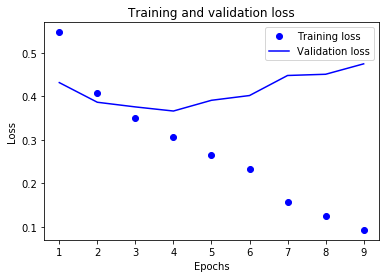

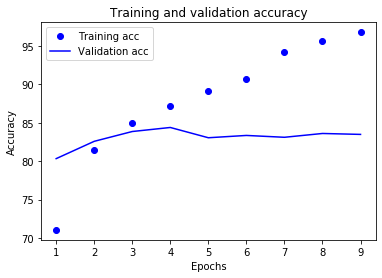

Test loss: 0.38782324641942983;
Test Accuracy: 82.61718749999999


In [34]:
plot_loss(train_state_base)
plot_acc(train_state_base)
class_test(cls_base, train_state_base)

#### With Glove

In [27]:
#run after deleting the previous pth file 
conf_base2,train_state_base2,cls_base2 = manually_tune(args)

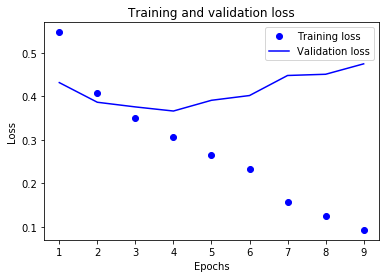

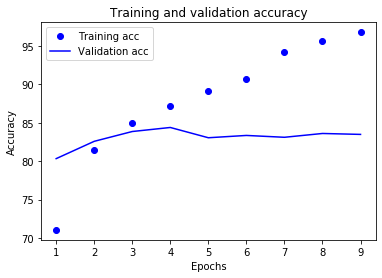

Test loss: 0.3876174415151279;
Test Accuracy: 82.35677083333336


In [35]:
plot_loss(train_state_base2)
plot_acc(train_state_base2)
class_test(cls_base2, train_state_base2)

### Hyperparameter Tune

In [45]:
config = Namespace( model_state_file='modelf.pth',
        hidden_dim=128, 
        num_channels = 512, 
        learning_rate= 0.0039, 
        dropout_p = 0.1, 
        batch_size=128,
        embedding_size =128)
conf,train_state,cls = manually_tune(config)

In [59]:
class_test(cls, train_state)

Test loss: 0.36643906931082404;
Test Accuracy: 84.37500000000001


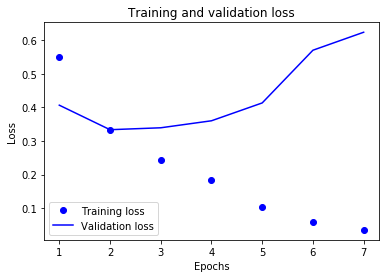

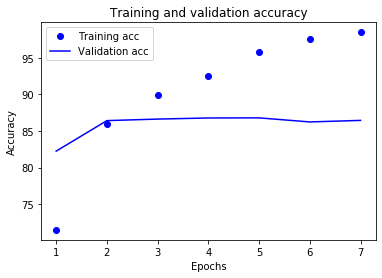

In [65]:
plot_loss(train_state)
plot_acc(train_state)

In [47]:
config1 = Namespace( model_state_file='modelg.pth',
        hidden_dim=200, 
        num_channels = 512, 
        learning_rate= 0.0039, 
        dropout_p = 0.1, 
        batch_size=200,
        embedding_size =200)
conf1,train_state1,cls1 = manually_tune(config1)

In [48]:
class_test(cls1, train_state1)

Test loss: 0.3632028425733248;
Test Accuracy: 83.3984375


In [49]:
ls_g2 = []
for i in range(20):
    config = Namespace( model_state_file='model' + str(i) + '.pth',
        hidden_dim=np.random.randint(100, 301), 
        num_channels=np.random.randint(400, 801), 
        learning_rate= np.random.randint(1,1000)/10000, 
        dropout_p=np.random.randint(1,4)/10, 
        batch_size=np.random.randint(100, 301),
        embedding_size = np.random.randint(100, 301))
    conf,train_state,cls = manually_tune(config)
    ls_g2.append((conf,train_state,cls))
ls_g2.sort(reverse = True, key = lambda x:np.mean(x[1]['val_acc']))

In [57]:
batch = []
drop = []
learning = []
channels = []
hdim = []
emb = []
mph = []
for i in ls_g2[0:10]:
    learning.append(i[0].learning_rate)
    batch.append(i[0].batch_size)
    channels.append(i[0].num_channels)
    drop.append(i[0].dropout_p)
    hdim.append(i[0].hidden_dim)
    emb.append(i[0].embedding_size)
    mph.append(i[0].model_state_file)
print(hdim)
print(channels)
print(learning)
print(drop)
print(batch)
print(emb)
print(mph)

[177, 222, 107, 211, 239, 296, 289, 110, 279, 108]
[706, 765, 603, 491, 789, 623, 793, 586, 464, 472]
[0.0077, 0.0379, 0.0322, 0.0436, 0.0747, 0.0994, 0.0965, 0.0776, 0.0529, 0.0574]
[0.1, 0.1, 0.3, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.3]
[145, 191, 261, 295, 269, 234, 235, 295, 233, 191]
[279, 255, 140, 248, 248, 296, 195, 287, 276, 237]
['model7.pth', 'model13.pth', 'model15.pth', 'model0.pth', 'model18.pth', 'model2.pth', 'model16.pth', 'model17.pth', 'model11.pth', 'model1.pth']


In [58]:
for i in range(10):
    class_test(ls_g2[i][2], ls_g2[i][1])

Test loss: 0.39067229504386586;
Test Accuracy: 83.07291666666669
Test loss: 0.42268443480134005;
Test Accuracy: 81.93359375
Test loss: 0.6941152364015579;
Test Accuracy: 48.63281250000001
Test loss: 0.6940125897526743;
Test Accuracy: 48.76302083333333
Test loss: 0.6939412405093511;
Test Accuracy: 48.86067708333334
Test loss: 0.694464792807897;
Test Accuracy: 48.4375
Test loss: 0.6942818860212961;
Test Accuracy: 48.63281250000001
Test loss: 0.6941864937543868;
Test Accuracy: 48.89322916666667
Test loss: 0.6940334116419158;
Test Accuracy: 48.274739583333336
Test loss: 0.6940964286526043;
Test Accuracy: 48.86067708333333


In [52]:
ls_g3 = []
for i in range(10):
    config = Namespace( model_state_file='model' + str(i+20) + '.pth',
        hidden_dim=np.random.randint(50, 250), 
        num_channels=512, 
        learning_rate= 0.0039, 
        dropout_p=0.1, 
        batch_size=np.random.randint(50, 250),
        embedding_size = np.random.randint(50, 250))
    conf,train_state,cls = manually_tune(config)
    ls_g3.append((conf,train_state,cls))
ls_g3.sort(reverse = True, key = lambda x:np.mean(x[1]['val_acc']))

In [53]:
for i in range(10):
    class_test(ls_g3[i][2], ls_g3[i][1])

Test loss: 0.36793509249885886;
Test Accuracy: 84.21223958333331
Test loss: 0.36864204580585164;
Test Accuracy: 83.72395833333336
Test loss: 0.36439028630654013;
Test Accuracy: 83.59375
Test loss: 0.38443634286522865;
Test Accuracy: 83.07291666666666
Test loss: 0.3776567863921324;
Test Accuracy: 83.52864583333331
Test loss: 0.38810342053572333;
Test Accuracy: 83.36588541666667
Test loss: 0.37137310331066453;
Test Accuracy: 83.98437500000001
Test loss: 0.3797226920723915;
Test Accuracy: 82.74739583333331
Test loss: 0.36804220328728354;
Test Accuracy: 83.85416666666666
Test loss: 0.3682546379665534;
Test Accuracy: 83.36588541666669


In [54]:
batch = []
drop = []
learning = []
channels = []
hdim = []
emb = []
mph = []
for i in ls_g3[0:10]:
    learning.append(i[0].learning_rate)
    batch.append(i[0].batch_size)
    channels.append(i[0].num_channels)
    drop.append(i[0].dropout_p)
    hdim.append(i[0].hidden_dim)
    emb.append(i[0].embedding_size)
    mph.append(i[0].model_state_file)
print(hdim)
print(channels)
print(learning)
print(drop)
print(batch)
print(emb)
print(mph)

[169, 172, 131, 131, 172, 128, 155, 133, 55, 81]
[512, 512, 512, 512, 512, 512, 512, 512, 512, 512]
[0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039, 0.0039]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[57, 229, 239, 240, 50, 73, 120, 57, 84, 100]
[237, 157, 141, 115, 87, 187, 227, 54, 195, 62]
['model29.pth', 'model26.pth', 'model24.pth', 'model27.pth', 'model23.pth', 'model22.pth', 'model20.pth', 'model28.pth', 'model25.pth', 'model21.pth']


In [55]:
config3 = Namespace( model_state_file='model26.pth',
        hidden_dim=np.random.randint(50, 250), 
        num_channels=np.random.randint(400, 801), 
        learning_rate= np.random.randint(1,1000)/100000, 
        dropout_p=0.2, 
        batch_size=np.random.randint(50, 250),
        embedding_size = np.random.randint(50, 250))
conf3,train_state3,cls3 = manually_tune(config3)

In [56]:
class_test(cls3, train_state3)
conf3

Test loss: 0.3904056077202161;
Test Accuracy: 83.56119791666669


Namespace(batch_size=56, dropout_p=0.2, embedding_size=172, hidden_dim=158, learning_rate=0.00557, model_state_file='model26.pth', num_channels=550)

### with Glove

In [36]:
args.use_glove = True
# create dataset and vectorizer
dataset = NewsDataset.load_dataset_and_make_vectorizer(args.news_csv)
vectorizer = dataset.get_vectorizer()

# Use GloVe or randomly initialized embeddings
if args.use_glove:
    words = vectorizer.title_vocab._token_to_idx.keys()  # 3409 unique words
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath,     # embeddings: (3409, 100)
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings


In [37]:
ls_g4 = []
for i in range(10):
    num = np.random.randint(50, 250)
    config = Namespace( model_state_file='model' + str(i+30) + '.pth',
        hidden_dim= num, 
        num_channels=np.random.randint(400, 801), 
        learning_rate= np.random.randint(1,1000)/10000, 
        dropout_p=0.1, 
        batch_size=num,
        embedding_size = 100)
    conf,train_state,cls = manually_tune(config)
    ls_g4.append((conf,train_state,cls))
ls_g4.sort(reverse = True, key = lambda x:np.mean(x[1]['val_acc']))

In [38]:
for i in range(10):
    class_test(ls_g4[i][2], ls_g4[i][1])

Test loss: 0.412032339721918;
Test Accuracy: 82.38932291666667
Test loss: 0.38851757968465483;
Test Accuracy: 82.51953125
Test loss: 0.42900310456752766;
Test Accuracy: 81.34765625000001
Test loss: 0.42887535194555926;
Test Accuracy: 80.33854166666666
Test loss: 0.41893529767791426;
Test Accuracy: 81.70572916666667
Test loss: 0.4371847858031591;
Test Accuracy: 79.78515625
Test loss: 0.5672432966530324;
Test Accuracy: 72.75390625
Test loss: 0.694110835591952;
Test Accuracy: 48.56770833333333
Test loss: 0.6893650293350221;
Test Accuracy: 53.548177083333336
Test loss: 0.692975364625454;
Test Accuracy: 51.46484375


In [39]:
batch = []
drop = []
learning = []
channels = []
hdim = []
emb = []
mph = []
for i in ls_g4[0:10]:
    learning.append(i[0].learning_rate)
    batch.append(i[0].batch_size)
    channels.append(i[0].num_channels)
    drop.append(i[0].dropout_p)
    hdim.append(i[0].hidden_dim)
    emb.append(i[0].embedding_size)
    mph.append(i[0].model_state_file)
print(hdim)
print(channels)
print(learning)
print(drop)
print(batch)
print(emb)
print(mph)

[143, 232, 164, 122, 217, 197, 202, 164, 201, 115]
[662, 746, 482, 665, 567, 638, 529, 505, 589, 460]
[0.0023, 0.0024, 0.0085, 0.0391, 0.0347, 0.0338, 0.0796, 0.0873, 0.0861, 0.0728]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[143, 232, 164, 122, 217, 197, 202, 164, 201, 115]
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
['model36.pth', 'model34.pth', 'model32.pth', 'model33.pth', 'model31.pth', 'model39.pth', 'model35.pth', 'model37.pth', 'model30.pth', 'model38.pth']


### Inference wih the best performed model

In [61]:
# Preprocess the reviews
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [62]:
def predict_category(title, classifier, vectorizer, max_length):
    """Predict a News category for a new title
    
    Args:
        title (str): a raw title string
        classifier (NewsClassifier): an instance of the trained classifier
        vectorizer (NewsVectorizer): the corresponding vectorizer
        max_length (int): the max sequence length
            Note: CNNs are sensitive to the input data tensor size. 
                  This ensures to keep it the same size as the training data
    """
    title = preprocess_text(title)
    vectorized_title = \
        torch.tensor(vectorizer.vectorize(title, vector_length=max_length))
    result = classifier(vectorized_title.unsqueeze(0), apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    predicted_category = vectorizer.category_vocab.lookup_index(indices.item())

    return {'category': predicted_category, 
            'probability': probability_values.item()}

In [66]:
def get_samples():
    samples = {}
    for cat in dataset.val_df.category.unique():
        samples[cat] = dataset.val_df.title[dataset.val_df.category==cat].tolist()[:10]
    return samples

val_samples = get_samples()

In [67]:
#title = input("Enter a news title to classify: ")

cls = cls.to("cpu")

for truth, sample_group in val_samples.items():
    print(f"True Category: {truth}")
    print("="*30)
    for sample in sample_group:
        prediction = predict_category(sample, cls, 
                                      vectorizer, dataset._max_seq_length + 1)
        print("Prediction: {} (p={:0.2f})".format(prediction['category'],
                                                  prediction['probability']))
        print("\t + Sample: {}".format(sample))
    print("-"*30 + "\n")

True Category: Positive
Prediction: Positive (p=0.95)
	 + Sample: us standing taking a hit b c of how badly we are handling coronavirus at home amp how little we re doing for others . china , despite its being where the virus began amp its dropping the ball at first , gaining influence b c it is meeting the challenge at home amp offering help to others
Prediction: Positive (p=0.84)
	 + Sample: i wonder how many men will be like the chap i seen in the supermarket now . . . he was on his hands and knees rummaging through hair color while on the phone to his other half . is it dark or medium ash brown ? covid irelandlockdown coronavirus https t . co ezos p rt
Prediction: Positive (p=0.91)
	 + Sample:  boblister poole ctsi uk just know people will remember when this is over . anyone affected please contact the consumer helpline on this is what they said jhootspharmacy i hope your taking note npa covid taking advant
Prediction: Positive (p=0.93)
	 + Sample: hey y all just wanna share my non

In [70]:
rating_classes = []
for i in range(len(dataset._vectorizer.category_vocab)):
    rating_classes.append(dataset._vectorizer.category_vocab.lookup_index(i))
print(rating_classes)

['Negative', 'Positive']


In [72]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
y_pred_list, y_target_list = class_test(cls, train_state)
cm = confusion_matrix(y_target_list, y_pred_list)
cm_df = pd.DataFrame(cm.T, index=rating_classes, columns=rating_classes)
cm_df.index.name = 'Predicted'
cm_df.columns.name = 'True'
print(cm_df)

Test loss: 0.36672539760669065;
Test Accuracy: 84.27734375
True       Negative  Positive
Predicted                    
Negative       1307       204
Positive        279      1282
